In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm
from scipy.stats import qmc
import math
import pandas as pd

2024-04-17 02:25:35.588169: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 02:25:35.650165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 02:25:36.522779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2024-04-17 02:25:38.179601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.230532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.230592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#torch.manual_seed(42)
#np.random.seed(42)

In [4]:
tf.keras.backend.set_floatx("float64")

In [5]:
class Puasson2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), alpha=1):
        super(Puasson2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)
        self.alpha = alpha

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer = tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model


    def forward(self, x1_x2):
        x1_x2 = tf.convert_to_tensor(x1_x2, dtype=tf.float64)
        
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x1_x2)
            with tf.GradientTape() as tape:
                tape.watch(x1_x2)
                u = self.model(x1_x2)
            grads = tape.gradient(u, x1_x2)
            u_x1, u_x2 = grads[:, 0], grads[:, 1]
        grads2 = tape2.gradient(u_x1, x1_x2)
        u_x1_x1 = grads2[:, 0]

        grads3 = tape2.gradient(u_x2, x1_x2)
        u_x2_x2 = grads3[:, 1]

        del tape2

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    @tf.function
    def dirichlet_condition(self, x1_bc, x2_bc, u_bc):
        x_t = tf.concat([x1_bc, x2_bc], axis=1)
        u = self.model(x_t)
        return 10 * tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def neuman_condition(self, x1_bc_neuman, x2_bc_neuman):
        x1_left = x1_bc_neuman[:len(x2_bc_neuman)//2]
        x2_left = x2_bc_neuman[:len(x2_bc_neuman)//2]
        x1_right = x1_bc_neuman[len(x2_bc_neuman)//2:]
        x2_right = x2_bc_neuman[len(x2_bc_neuman)//2:]
        x1_x2_left = tf.concat([x1_left, x2_left], axis=1)
        x1_x2_right = tf.concat([x1_right, x2_right], axis=1)

        u_left = self.model(x1_x2_left)
        u_x1_left = tf.gradients(u_left, x1_left)[0]
        u_right = self.model(x1_x2_right)
        u_x1_right = tf.gradients(u_right, x1_right)[0]

        return tf.reduce_mean(tf.square(-u_x1_left)) + 2 * tf.reduce_mean(tf.square(u_x1_right - self.alpha * u_right))

    @tf.function
    def loss_fn(self, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        x_t = tf.concat([x1_in, x2_in], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x1_in)[0]
        u_y = tf.gradients(u0, x2_in)[0]
        u_xx = tf.gradients(u_x, x1_in)[0]
        u_yy = tf.gradients(u_y, x2_in)[0]
        puasson_eq = u_xx + u_yy #self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_bc, x2_bc, u_bc)
        bc_neuman = self.neuman_condition(x1_bc_neuman, x2_bc_neuman)

        return tf.reduce_mean(tf.square(puasson_eq)) + (bc_dirichlet + bc_neuman)
    
    def train(self, loss_threshold, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        loss_array = []
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.numpy()}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("2d_poisson_robin_equation_training.png")
        plt.show(block=False)

    # def f(self, x1_x2):
    #     x1 = np.array([x[0] for x in x1_x2])
    #     x2 = np.array([x[1] for x in x1_x2])
    #     return -np.pi * np.sin(np.pi * x1) * np.sin(np.pi * x2)

2024-04-17 02:25:38.295350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.295504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.295533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.439461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 02:25:38.439546: I tensorflow/compile

In [6]:
N_of_train_points_for_one_axis_2D = 11
N_of_test_points_2D = 1000
N_of_fem_points_2D = 10
L_x1 = 0.0
R_x1 = 1.0
L_x2 = 0.0
R_x2 = 1.0
alpha = 1
Dirichlet_up_2D = 1.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-3
Layers_2D = [10, 10, 10]
Learning_rate_2D = 1e-2
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)

In [7]:
model_2D = Puasson2DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D, alpha)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


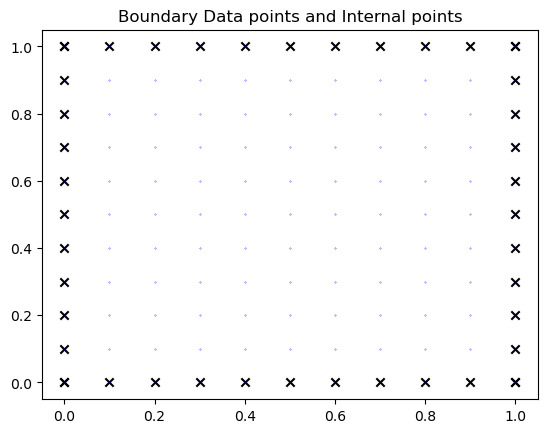

In [8]:
n_bc = 4
n_bc_dirichlet = 2
n_bc_neuman = 2
n_data_per_bc = N_of_train_points_for_one_axis_2D
Nc = N_of_train_points_for_one_axis_2D * N_of_train_points_for_one_axis_2D

engine = qmc.LatinHypercube(d=1)
data_dirichlet = np.zeros([2, n_data_per_bc, 3])
data_neuman = np.zeros([2, n_data_per_bc, 3])

for i, j in zip(range(n_bc_dirichlet), [L_x2, R_x2]):
    points = L_x1 + np.linspace(0, 1, n_data_per_bc) * (R_x1 - L_x1) #engine.random(n=n_data_per_bc)[:, 0]
    data_dirichlet[i, :, 0] = points
    data_dirichlet[i, :, 1] = j

for i, j in zip(range(n_bc_neuman), [L_x1, R_x1]):
    points = L_x2 + np.linspace(0, 1, n_data_per_bc) * (R_x2 - L_x2) #engine.random(n=n_data_per_bc)[:, 0]
    data_neuman[i, :, 0] = j
    data_neuman[i, :, 1] = points

# BC Values
data_dirichlet[0, :, 2] = 0.0
data_dirichlet[1, :, 2] = 1.0

data_dirichlet = data_dirichlet.reshape(n_data_per_bc * n_bc_dirichlet, 3)
data_neuman = data_neuman.reshape(n_data_per_bc * n_bc_neuman, 3)

x1_bc, x2_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_dirichlet[:, 0], data_dirichlet[:, 1], data_dirichlet[:, 2]])

x1_bc_neuman, x2_bc_neuman = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_neuman[:, 0], data_neuman[:, 1]])

# engine = qmc.LatinHypercube(d=2)
# colloc = engine.random(n=Nc)

X_1, X_2 = np.meshgrid(np.linspace(0, 1, N_of_train_points_for_one_axis_2D), np.linspace(0, 1, N_of_train_points_for_one_axis_2D))
colloc = np.vstack([X_1.ravel(), X_2.ravel()]).T

colloc = np.column_stack((L_x1 + colloc[:,0] * (R_x1 - L_x1), L_x2 + colloc[:,1] * (R_x2 - L_x2)))

x1_in, x2_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Internal points")
plt.scatter(data_dirichlet[:, 0], data_dirichlet[:, 1], marker="x", c="k", label="BDP")
plt.scatter(data_neuman[:, 0], data_neuman[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
plt.show()

x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman]
)

2024-04-17 02:25:39.885273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11}}]]
2024-04-17 02:25:40.061237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_4' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_4}}]]
2024-04-17 02:25:40.061373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start a

Epoch: 0, Loss: 11.719070751349019
Epoch: 100, Loss: 0.35976031308969614
Epoch: 200, Loss: 0.19436397981098696
Epoch: 300, Loss: 0.09753527724094373
Epoch: 400, Loss: 0.076707461181628
Epoch: 500, Loss: 0.05465542690595339
Epoch: 600, Loss: 0.04177306081790459
Epoch: 700, Loss: 0.02771529088876436
Epoch: 800, Loss: 0.020461590675942047
Epoch: 900, Loss: 0.016266855554592556
Epoch: 1000, Loss: 0.015789177615294185
Epoch: 1100, Loss: 0.012090381192295895
Epoch: 1200, Loss: 0.010881256992789232
Epoch: 1300, Loss: 0.010037932754246826
Epoch: 1400, Loss: 0.012872898604712163
Epoch: 1500, Loss: 0.00894681923201139
Epoch: 1600, Loss: 0.008582511421386068
Epoch: 1700, Loss: 0.008650649070376897
Epoch: 1800, Loss: 0.009364620299221079
Epoch: 1900, Loss: 0.008080256182921568
Epoch: 2000, Loss: 0.007672849890787709
Epoch: 2100, Loss: 0.007269470316949611
Epoch: 2200, Loss: 0.006296372950996628
Epoch: 2300, Loss: 0.006995995692713874
Epoch: 2400, Loss: 0.010183440122026061
Epoch: 2500, Loss: 0.006

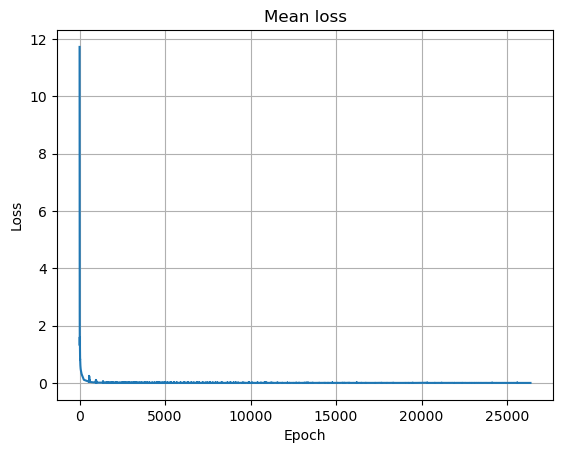

In [9]:
model_2D.train(loss_threshold_2D, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)

In [10]:
x1_test = np.linspace(L_x1, R_x1, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2, R_x2, N_of_test_points_2D)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

u_pinn = model_2D.model(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

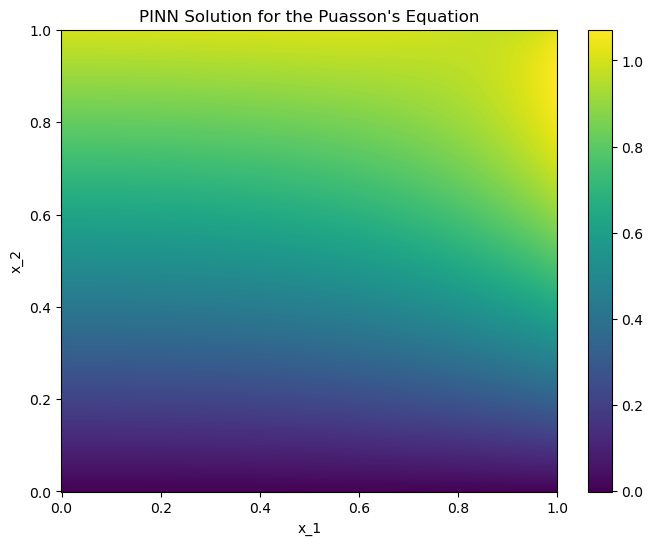

In [11]:
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('PINN Solution for the Puasson\'s Equation')
plt.savefig("2d_poisson_robin_equation_exact_solution_heatmap.png")
plt.show(block=False)

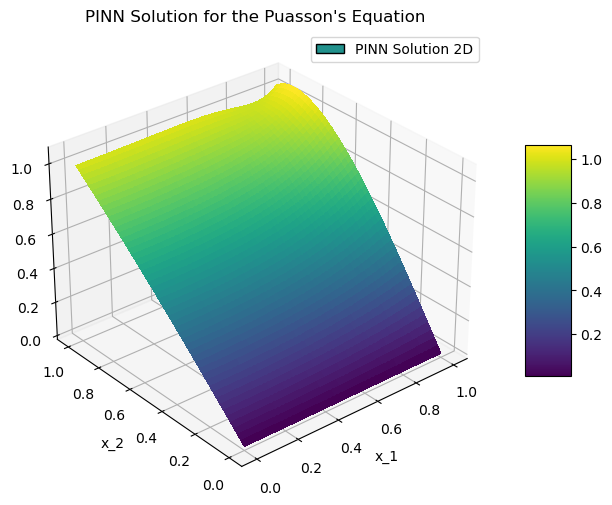

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# line, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, u_pred_1D, label='PINN Solution 1D', zorder=2)
# line2, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D', zorder=1)
surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
#ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title('PINN Solution for the Puasson\'s Equation')
color_for_legend = cm.viridis(0.5)
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])
#ax.legend([line, line2, proxy], ['PINN Solution 1D', 'Exact Solution 1D', 'PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=-130)
plt.savefig("2d_poisson_robin_equation_approx_solution.png")
plt.show()

bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)


Solving linear variational problem.


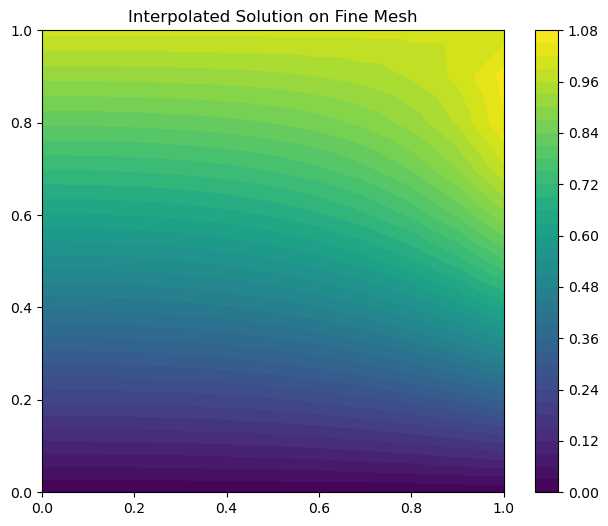

In [13]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

def solve_with_fem(N_coarse, N_fine):
    # Create a coarse mesh and a corresponding function space
    coarse_mesh = UnitSquareMesh(N_coarse, N_coarse)
    V_coarse = FunctionSpace(coarse_mesh, 'P', 1)

    # Define boundary conditions
    u_top = Constant(1.0)
    u_bottom = Constant(0.0)

    def boundary_top(x, on_boundary):
        return on_boundary and near(x[1], 1)

    def boundary_bottom(x, on_boundary):
        return on_boundary and near(x[1], 0)

    bc_top = DirichletBC(V_coarse, u_top, boundary_top)
    bc_bottom = DirichletBC(V_coarse, u_bottom, boundary_bottom)
    bcs = [bc_top, bc_bottom]

    # Define the variational problem
    u = TrialFunction(V_coarse)
    v = TestFunction(V_coarse)
    f = Constant(0)
    a = dot(grad(u), grad(v))*dx
    L = f*v*dx

    # Additional boundary condition integration
    class RightBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1)

    right_boundary = RightBoundary()
    boundary_markers = MeshFunction('size_t', coarse_mesh, coarse_mesh.topology().dim()-1, 0)
    right_boundary.mark(boundary_markers, 1)
    ds = Measure('ds', domain=coarse_mesh, subdomain_data=boundary_markers)
    a += Constant(-alpha)*u*v*ds(1)
    L += Constant(0)*v*ds(1)

    # Solve the problem
    u = Function(V_coarse)
    solve(a == L, u, bcs)

    # Interpolate the solution to a finer mesh
    fine_mesh = UnitSquareMesh(N_fine, N_fine)
    V_fine = FunctionSpace(fine_mesh, 'P', 1)
    u_fine = interpolate(u, V_fine)
    u_fem = u_fine.compute_vertex_values(fine_mesh).reshape((N_fine+1, N_fine+1))

    return fine_mesh, u_fine, u_fem


fine_mesh, u_fine, u_fem = solve_with_fem(N_of_fem_points_2D, N_of_test_points_2D-1)

plt.figure(figsize=(8, 6))
c = plot(u_fine)
plt.colorbar(c)
plt.title('Interpolated Solution on Fine Mesh')
plt.show()


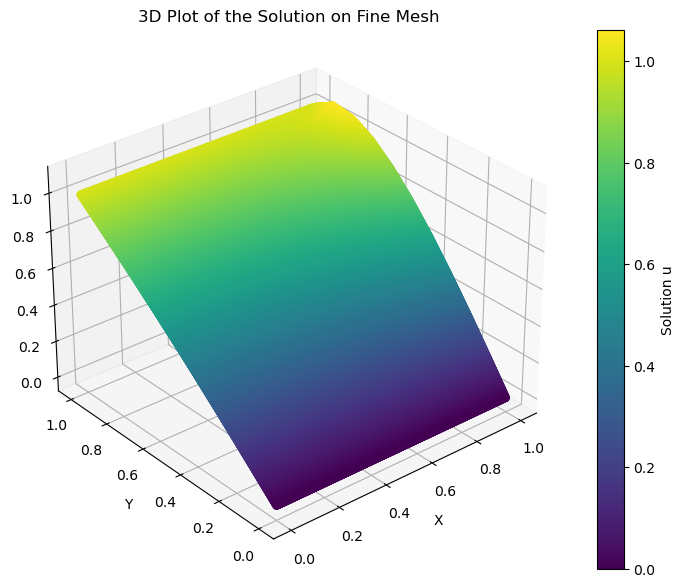

In [34]:
# 3D plot
x = fine_mesh.coordinates()[:, 0]
y = fine_mesh.coordinates()[:, 1]
z = u_fem.flatten()  # Flatten to match x, y dimensions for 3D plotting

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis')
fig.colorbar(scatter, ax=ax, label='Solution u')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title('3D Plot of the Solution on Fine Mesh')
ax.view_init(elev=30, azim=-130)
plt.show()

In [15]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [16]:
def relative_l2_norm_error(u_pred, u_true):
    error_norm = np.linalg.norm(u_true - u_pred)
    true_norm = np.linalg.norm(u_true)
    return error_norm / true_norm

In [17]:
print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))

relative_error = calculate_max_relative_error(u_fem, u_pinn)
print(f"Relative l^inf error (PINN and FEM): {relative_error:.2f}%")
relative_l2_error = relative_l2_norm_error(u_fem, u_pinn)
print(f"Relative l_2 error (PINN and FEM): {relative_l2_error:.2f}%")


Mean Squared Error (PINN and FEM): 6.310158947626722e-06
Relative l^inf error (PINN and FEM): 2.99%
Relative l_2 error (PINN and FEM): 0.00%


In [18]:
fine_mesh_10, u_fine_10, u_fem_10 = solve_with_fem(10, N_of_test_points_2D-1)
fine_mesh_20, u_fine_20, u_fem_20 = solve_with_fem(20, N_of_test_points_2D-1)
fine_mesh_50, u_fine_50, u_fem_50 = solve_with_fem(50, N_of_test_points_2D-1)
#fine_mesh_100, u_fine_100, u_fem_100 = solve_with_fem(100, N_of_test_points_2D-1)

x1_positions = np.linspace(L_x1, R_x1, N_of_test_points_2D)
x2_positions = np.linspace(L_x2, R_x2, N_of_test_points_2D)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


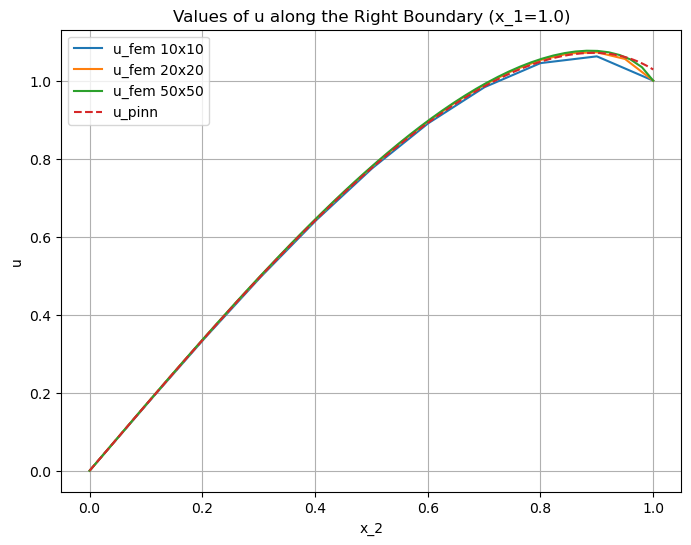

In [19]:
right_index = -1
right_boundary_fem_values_10 = u_fem_10[:, right_index]
right_boundary_fem_values_20 = u_fem_20[:, right_index]
right_boundary_fem_values_50 = u_fem_50[:, right_index]
right_boundary_pinn_values = u_pinn[:, right_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, right_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x2_positions, right_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x2_positions, right_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x2_positions, right_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_2')
plt.ylabel('u')
plt.title(f'Values of u along the Right Boundary (x_1={x1_positions[right_index]})')
plt.legend()
plt.grid(True)
plt.show()

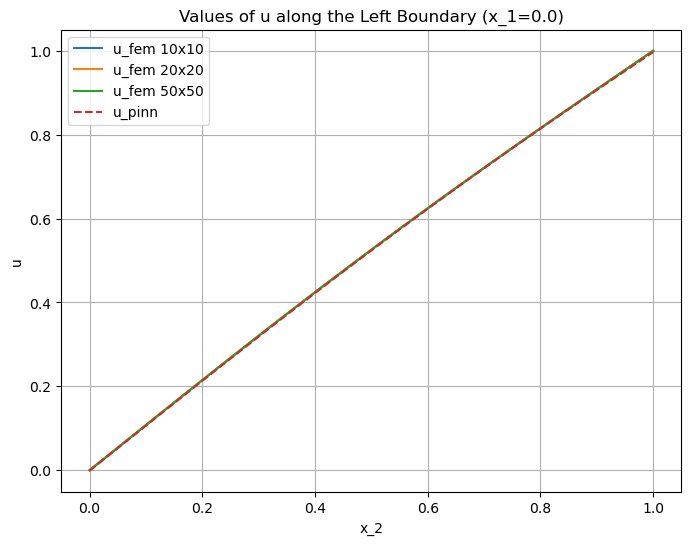

In [20]:
left_index = 0
left_boundary_fem_values_10 = u_fem_10[:, left_index]
left_boundary_fem_values_20 = u_fem_20[:, left_index]
left_boundary_fem_values_50 = u_fem_50[:, left_index]
left_boundary_pinn_values = u_pinn[:, left_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, left_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x2_positions, left_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x2_positions, left_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x2_positions, left_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_2')
plt.ylabel('u')
plt.title(f'Values of u along the Left Boundary (x_1={x1_positions[left_index]})')
plt.legend()
plt.grid(True)
plt.show()

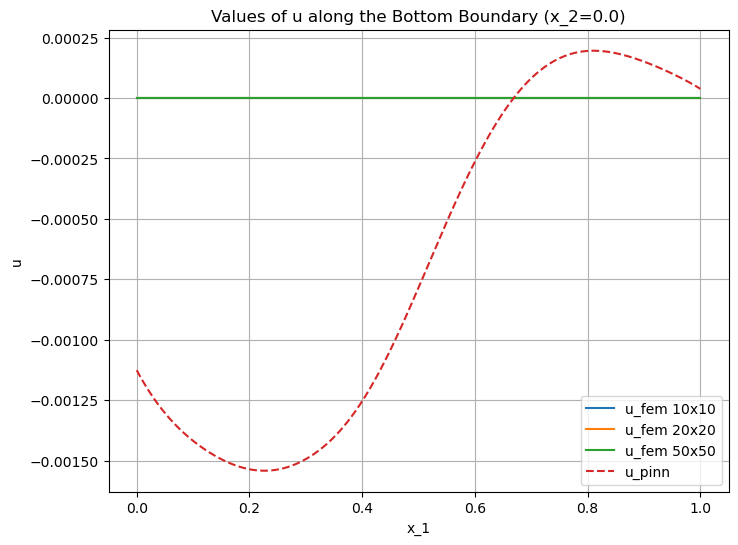

In [21]:
bottom_index = 0
bottom_boundary_fem_values_10 = u_fem_10[bottom_index, :]
bottom_boundary_fem_values_20 = u_fem_20[bottom_index, :]
bottom_boundary_fem_values_50 = u_fem_50[bottom_index, :]
bottom_boundary_pinn_values = u_pinn[bottom_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, bottom_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x1_positions, bottom_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x1_positions, bottom_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x1_positions, bottom_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_1')
plt.ylabel('u')
plt.title(f'Values of u along the Bottom Boundary (x_2={x2_positions[bottom_index]})')
plt.legend()
plt.grid(True)
plt.show()

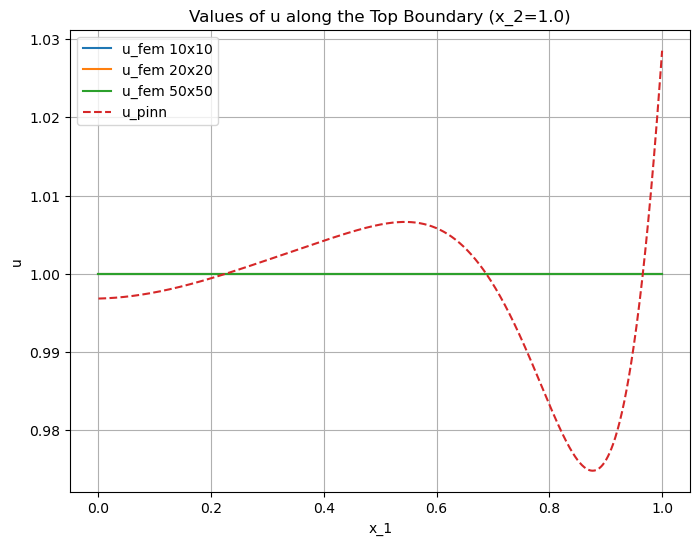

In [22]:
top_index = -1
top_boundary_fem_values_10 = u_fem_10[top_index, :]
top_boundary_fem_values_20 = u_fem_20[top_index, :]
top_boundary_fem_values_50 = u_fem_50[top_index, :]
top_boundary_pinn_values = u_pinn[top_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, top_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x1_positions, top_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x1_positions, top_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x1_positions, top_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_1')
plt.ylabel('u')
plt.title(f'Values of u along the Top Boundary (x_2={x2_positions[top_index]})')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Indices for 11 equally spaced points including both ends (0 and 1)
indices = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error

# Creating a table for the selected points
data_right = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": right_boundary_fem_values_10[indices],
    "FEM 20x20": right_boundary_fem_values_20[indices],
    "FEM 50x50": right_boundary_fem_values_50[indices],
    "PINN": right_boundary_pinn_values[indices]
}

df_right = pd.DataFrame(data_right)
print(f"Values on right boundary (x_1={x1_positions[right_index]}):")
print(df_right)

data_left = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": left_boundary_fem_values_10[indices],
    "FEM 20x20": left_boundary_fem_values_20[indices],
    "FEM 50x50": left_boundary_fem_values_50[indices],
    "PINN": left_boundary_pinn_values[indices]
}

df_left = pd.DataFrame(data_left)
print(f"Values on left boundary (x_1={x1_positions[left_index]}):")
print(df_left)


Values on right boundary (x_1=1.0):
         x_2  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   0.000000   0.000000   0.000000  0.000038
1   0.099099   0.166720   0.167624   0.167882  0.167441
2   0.199199   0.331838   0.333647   0.334164  0.333180
3   0.299299   0.490298   0.492994   0.493762  0.492039
4   0.399399   0.638613   0.642175   0.643188  0.640428
5   0.499499   0.773059   0.777478   0.778730  0.774770
6   0.599600   0.889436   0.894752   0.896250  0.891202
7   0.699700   0.982542   0.988939   0.990721  0.984740
8   0.799800   1.044818   1.052864   1.055090  1.048385
9   0.899900   1.062267   1.072906   1.076412  1.071092
10  1.000000   1.000000   1.000000   1.000000  1.028517
Values on left boundary (x_1=0.0):
         x_2  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   0.000000   0.000000   0.000000 -0.001126
1   0.099099   0.106839   0.106861   0.106868  0.105414
2   0.199199   0.214037   0.214077   0.214090  0.212248
3   0.299299   0.319844   0.31989

In [24]:
data_top = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": top_boundary_fem_values_10[indices],
    "FEM 20x20": top_boundary_fem_values_20[indices],
    "FEM 50x50": top_boundary_fem_values_50[indices],
    "PINN": top_boundary_pinn_values[indices]
}

df_top = pd.DataFrame(data_top)
print(f"Values on top boundary (x_2={x2_positions[top_index]}):")
print(df_top)

data_bottom = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": bottom_boundary_fem_values_10[indices],
    "FEM 20x20": bottom_boundary_fem_values_20[indices],
    "FEM 50x50": bottom_boundary_fem_values_50[indices],
    "PINN": bottom_boundary_pinn_values[indices]
}

df_bottom = pd.DataFrame(data_bottom)
print(f"Values on bottom boundary (x_2={x2_positions[bottom_index]}):")
print(df_bottom)

Values on top boundary (x_2=1.0):
         x_1  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000        1.0        1.0        1.0  0.996826
1   0.099099        1.0        1.0        1.0  0.997608
2   0.199199        1.0        1.0        1.0  0.999408
3   0.299299        1.0        1.0        1.0  1.001752
4   0.399399        1.0        1.0        1.0  1.004215
5   0.499499        1.0        1.0        1.0  1.006283
6   0.599600        1.0        1.0        1.0  1.005831
7   0.699700        1.0        1.0        1.0  0.998696
8   0.799800        1.0        1.0        1.0  0.983302
9   0.899900        1.0        1.0        1.0  0.976114
10  1.000000        1.0        1.0        1.0  1.028517
Values on bottom boundary (x_2=0.0):
         x_1  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000        0.0        0.0        0.0 -0.001126
1   0.099099        0.0        0.0        0.0 -0.001417
2   0.199199        0.0        0.0        0.0 -0.001536
3   0.299299        0.0        0.

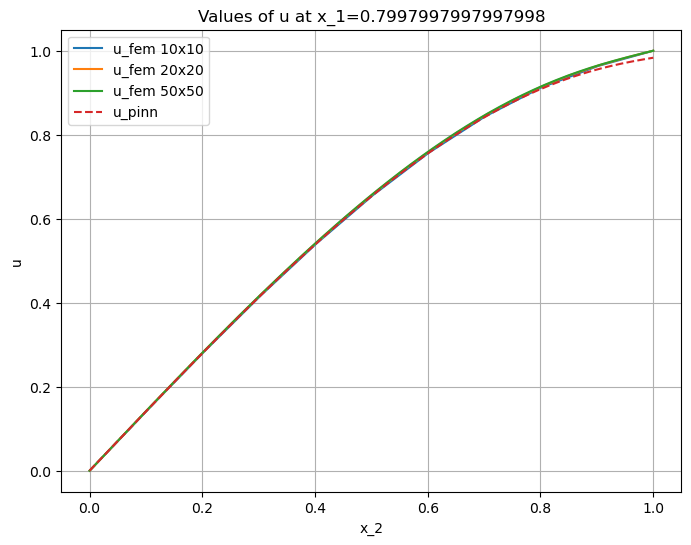

In [25]:
right_offset_index = int((0.8 - L_x1) / ((R_x1 - L_x1) / (N_of_test_points_2D - 1)))
right_offset_boundary_fem_values_10 = u_fem_10[:, right_offset_index]
right_offset_boundary_fem_values_20 = u_fem_20[:, right_offset_index]
right_offset_boundary_fem_values_50 = u_fem_50[:, right_offset_index]
right_offset_boundary_pinn_values = u_pinn[:, right_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, right_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x2_positions, right_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x2_positions, right_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x2_positions, right_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_2')
plt.ylabel('u')
plt.title(f'Values of u at x_1={x1_positions[right_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

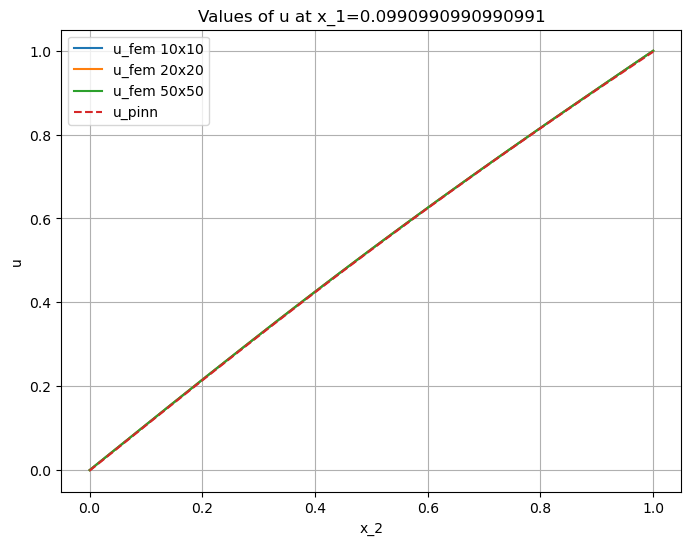

In [26]:
left_offset_index = int((0.1 - L_x1) / ((R_x1 - L_x1) / (N_of_test_points_2D - 1)))
left_offset_boundary_fem_values_10 = u_fem_10[:, left_offset_index]
left_offset_boundary_fem_values_20 = u_fem_20[:, left_offset_index]
left_offset_boundary_fem_values_50 = u_fem_50[:, left_offset_index]
left_offset_boundary_pinn_values = u_pinn[:, left_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, left_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x2_positions, left_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x2_positions, left_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x2_positions, left_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_2')
plt.ylabel('u')
plt.title(f'Values of u at x_1={x1_positions[left_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

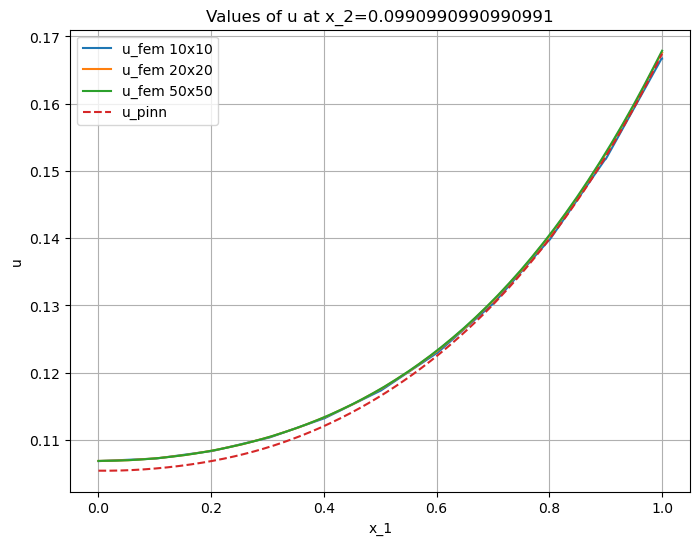

In [27]:
bottom_offset_index = int((0.1 - L_x2) / ((R_x2 - L_x2) / (N_of_test_points_2D - 1)))
bottom_offset_boundary_fem_values_10 = u_fem_10[bottom_offset_index, :]
bottom_offset_boundary_fem_values_20 = u_fem_20[bottom_offset_index, :]
bottom_offset_boundary_fem_values_50 = u_fem_50[bottom_offset_index, :]
bottom_offset_boundary_pinn_values = u_pinn[bottom_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, bottom_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x1_positions, bottom_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x1_positions, bottom_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x1_positions, bottom_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_1')
plt.ylabel('u')
plt.title(f'Values of u at x_2={x2_positions[bottom_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

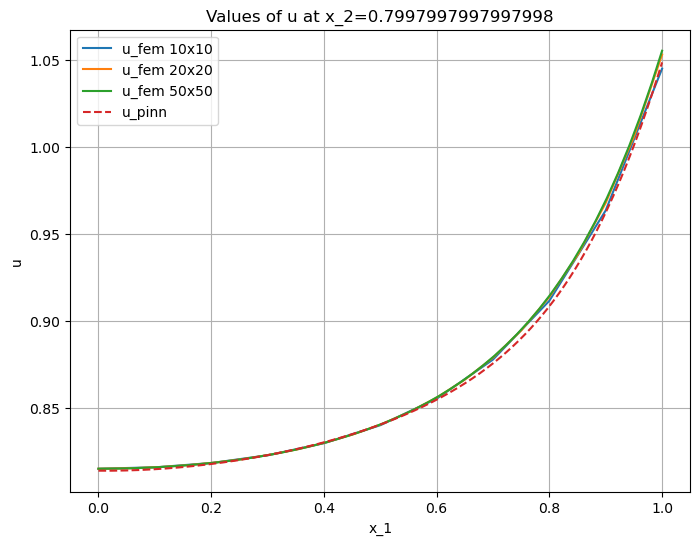

In [28]:
top_offset_index = int((0.8 - L_x2) / ((R_x2 - L_x2) / (N_of_test_points_2D - 1)))
top_offset_boundary_fem_values_10 = u_fem_10[top_offset_index, :]
top_offset_boundary_fem_values_20 = u_fem_20[top_offset_index, :]
top_offset_boundary_fem_values_50 = u_fem_50[top_offset_index, :]
top_offset_boundary_pinn_values = u_pinn[top_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, top_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x1_positions, top_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x1_positions, top_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x1_positions, top_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x_1')
plt.ylabel('u')
plt.title(f'Values of u at x_2={x2_positions[top_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Indices for 11 equally spaced points including both ends (0 and 1)
indices = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error

# Creating a table for the selected points
data_right = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": right_boundary_fem_values_10[indices],
    "FEM 20x20": right_boundary_fem_values_20[indices],
    "FEM 50x50": right_boundary_fem_values_50[indices],
    "PINN": right_boundary_pinn_values[indices]
}

df_right = pd.DataFrame(data_right)
print(f"Values at x_1={x1_positions[right_offset_index]}:")
print(df_right)

data_left = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": left_boundary_fem_values_10[indices],
    "FEM 20x20": left_boundary_fem_values_20[indices],
    "FEM 50x50": left_boundary_fem_values_50[indices],
    "PINN": left_boundary_pinn_values[indices]
}

df_left = pd.DataFrame(data_left)
print(f"Values at x_1={x1_positions[left_offset_index]}:")
print(df_left)


Values at x_1=0.7997997997997998:
         x_2  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   0.000000   0.000000   0.000000  0.000038
1   0.099099   0.166720   0.167624   0.167882  0.167441
2   0.199199   0.331838   0.333647   0.334164  0.333180
3   0.299299   0.490298   0.492994   0.493762  0.492039
4   0.399399   0.638613   0.642175   0.643188  0.640428
5   0.499499   0.773059   0.777478   0.778730  0.774770
6   0.599600   0.889436   0.894752   0.896250  0.891202
7   0.699700   0.982542   0.988939   0.990721  0.984740
8   0.799800   1.044818   1.052864   1.055090  1.048385
9   0.899900   1.062267   1.072906   1.076412  1.071092
10  1.000000   1.000000   1.000000   1.000000  1.028517
Values at x_1=0.0990990990990991:
         x_2  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   0.000000   0.000000   0.000000 -0.001126
1   0.099099   0.106839   0.106861   0.106868  0.105414
2   0.199199   0.214037   0.214077   0.214090  0.212248
3   0.299299   0.319844   0.319894  

In [30]:
data_top = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": top_boundary_fem_values_10[indices],
    "FEM 20x20": top_boundary_fem_values_20[indices],
    "FEM 50x50": top_boundary_fem_values_50[indices],
    "PINN": top_boundary_pinn_values[indices]
}

df_top = pd.DataFrame(data_top)
print(f"Values at x_2={x2_positions[top_offset_index]}:")
print(df_top)

data_bottom = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": bottom_boundary_fem_values_10[indices],
    "FEM 20x20": bottom_boundary_fem_values_20[indices],
    "FEM 50x50": bottom_boundary_fem_values_50[indices],
    "PINN": bottom_boundary_pinn_values[indices]
}

df_bottom = pd.DataFrame(data_bottom)
print(f"Values at x_2={x2_positions[bottom_offset_index]}:")
print(df_bottom)

Values at x_2=0.7997997997997998:
         x_1  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000        1.0        1.0        1.0  0.996826
1   0.099099        1.0        1.0        1.0  0.997608
2   0.199199        1.0        1.0        1.0  0.999408
3   0.299299        1.0        1.0        1.0  1.001752
4   0.399399        1.0        1.0        1.0  1.004215
5   0.499499        1.0        1.0        1.0  1.006283
6   0.599600        1.0        1.0        1.0  1.005831
7   0.699700        1.0        1.0        1.0  0.998696
8   0.799800        1.0        1.0        1.0  0.983302
9   0.899900        1.0        1.0        1.0  0.976114
10  1.000000        1.0        1.0        1.0  1.028517
Values at x_2=0.0990990990990991:
         x_1  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000        0.0        0.0        0.0 -0.001126
1   0.099099        0.0        0.0        0.0 -0.001417
2   0.199199        0.0        0.0        0.0 -0.001536
3   0.299299        0.0        0.0  